# Fantasy Football Exploratory Data Analysis
* Analysis of League Data
* Brock Ricker
* Last Edited: 07/09/2022

In [1]:
#import modules here
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sqlalchemy import create_engine, inspect

In [2]:
# create sqlite engine for fantasy_league db
engine = create_engine("sqlite:///fantasy_football_data.db", echo=True)
#create connection to the engine
conn = engine.connect()

In [3]:
#creating inspector
inspector = inspect(engine)

In [5]:
#using the inspector to view tables
inspector.get_table_names()

['adp',
 'league_teams',
 'points_allowed',
 'projected_scores',
 'simple_players',
 'spreads',
 'weekly_matchup',
 'weekly_players',
 'weekly_teams']

# Results by Player

In [37]:
#weekly points per player and position query 
sql = """
SELECT sp.name, sp.id, sp.team, sp.position, sp.rookie, wp.score, wp.status, wp.should_start, wp.week, wp.year, wp.regular_season, sp.name
FROM weekly_players as wp
LEFT JOIN simple_players as sp
ON wp.id = sp.id AND wp.year = sp.year
"""

df = pd.read_sql_query(sql, engine)

2022-07-09 12:22:05,376 INFO sqlalchemy.engine.Engine 
SELECT sp.name, sp.id, sp.team, sp.position, sp.rookie, wp.score, wp.status, wp.should_start, wp.week, wp.year, wp.regular_season, sp.name
FROM weekly_players as wp
LEFT JOIN simple_players as sp
ON wp.id = sp.id AND wp.year = sp.year

2022-07-09 12:22:05,376 INFO sqlalchemy.engine.Engine [raw sql] ()


In [39]:
# filtering to starters only
starters = df.loc[df["status"]=="starter"]

# dropping null scores, these are from score  = 0 this means the player most likely started someone they shoud not have
starters = starters.dropna()

#selecting only regular season games
starters = starters.loc[starters["regular_season"]==1]

In [44]:
#group by position
scores_by_pos = starters.groupby(by=["position"], as_index=False).mean().round(2)

In [46]:
#group by position and year
scores_by_pos_year = starters.groupby(by=["position","year"], as_index=False).mean().round(2)

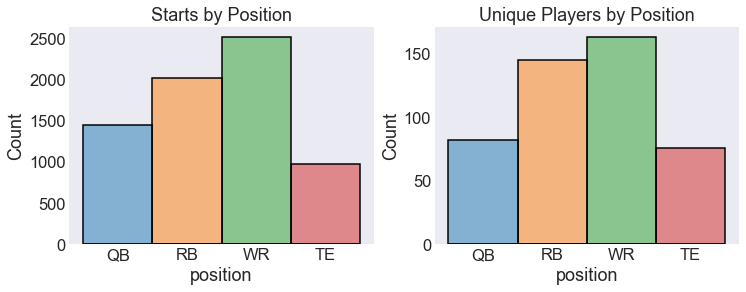

In [98]:
#set style
sns.set_context('talk')
plt.style.use('seaborn-dark')

#figures size
plt.figure(figsize= (12,4))

#plot starts by pos
plt.subplot(1,2,1)
plt.title("Starts by Position")
sns.histplot(data = starters, x = "position", hue="position")
plt.legend([],[], frameon=False)

#unique players
unique_players = starters.drop_duplicates(subset=["id"])

#plot unique players by pos
plt.subplot(1,2,2)
plt.title("Unique Players by Position")
sns.histplot(data = unique_players, x = "position", hue="position")
plt.legend([],[], frameon=False)

In [117]:
#Position based graphs

def pos_graph(df,attribute):

    #set style
    sns.set_context('talk')
    plt.style.use('seaborn-dark')
    
    #figures size
    plt.figure(figsize= (12,8))
    
    positions = df["position"].unique()
    for i, pos in enumerate(positions):
        j = i+1
        plt.subplot(2,2,j)
        plt.title(f"{pos}s")
        pos_score = df.loc[(df["position"] == f"{pos}")]
        sns.histplot(data = pos_score, x = attribute)
        plt.axvline(x=pos_score[attribute].median(), color="green", ls="--", label="50%")
        plt.axvline(x=pos_score[attribute].quantile(q=0.9), color="red", ls="--", label="90%")
        plt.legend()
    plt.tight_layout()
    plt.show()

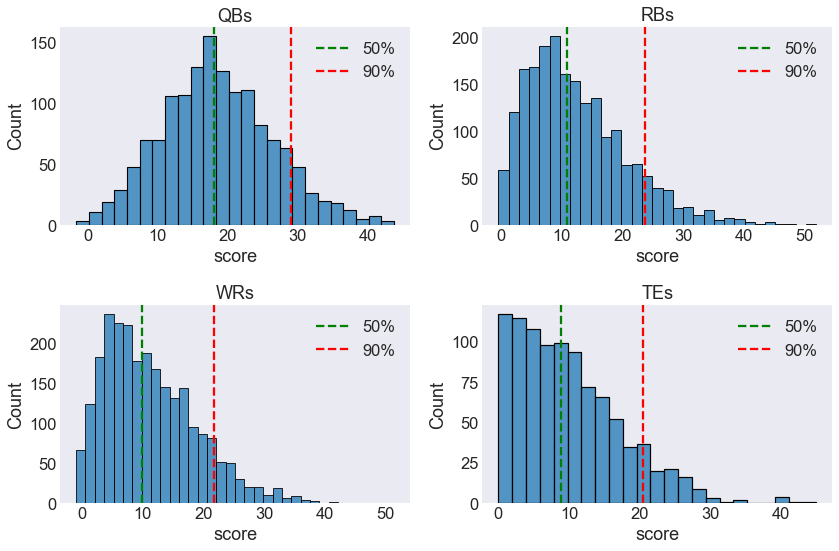

In [118]:
pos_graph(starters,"score")

In [151]:
#getting median and 90th percentail score per position
positions = df["position"].unique()
for pos in positions:
    pos_score = starters.loc[(starters["position"] == f"{pos}")]
    print(pos,": { median :",pos_score["score"].median(),", 90th :",pos_score["score"].quantile(q=0.9).round(2),"}")

QB : { median : 18.02 , 90th : 28.97 }
RB : { median : 10.9 , 90th : 23.7 }
WR : { median : 9.9 , 90th : 21.8 }
TE : { median : 8.8 , 90th : 20.5 }


# Results by Fantasy Team

In [100]:
#weekly points per player and position query 
sql = """
SELECT *
FROM weekly_teams
"""

team_df = pd.read_sql_query(sql, engine)

2022-07-09 13:17:52,524 INFO sqlalchemy.engine.Engine 
SELECT *
FROM weekly_teams

2022-07-09 13:17:52,525 INFO sqlalchemy.engine.Engine [raw sql] ()


In [108]:
#converting optimal points to float
team_df = team_df.astype({"opt_pts":float})

In [145]:
#calculating "missed" points: (optimal points) - (score)
team_df["missed_points"] = team_df["opt_pts"] - team_df["score"]
#displaying statistics
team_df.describe()

,index,opt_pts,score,id,is_home,week,year,regular_season,missed_points
count,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000
mean,5.218310,138.848697,114.508181,6.350939,0.500000,7.676056,2019.028169,0.929577,24.340516
std,3.496749,28.101152,27.447718,3.458002,0.500294,4.226628,1.424696,0.256008,14.456785
min,0.000000,42.980000,26.580000,1.000000,0.000000,1.000000,2017.000000,0.000000,-5.500000
25%,2.000000,120.167500,95.495000,3.000000,0.000000,4.000000,2018.000000,1.000000,13.300000
50%,5.000000,140.050000,114.315000,6.000000,0.500000,8.000000,2019.000000,1.000000,22.680000
75%,8.000000,157.920000,132.665000,9.000000,1.000000,11.000000,2020.000000,1.000000,32.367500
max,11.000000,254.320000,215.320000,12.000000,1.000000,17.000000,2021.000000,1.000000,89.400000


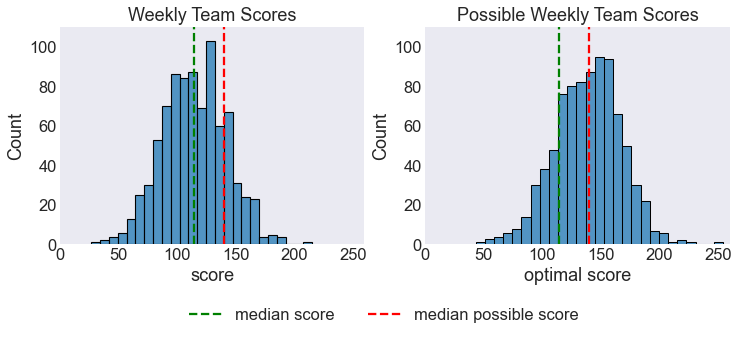

In [146]:
#set style
sns.set_context('talk')
plt.style.use('seaborn-dark')

#figures size
plt.figure(figsize= (12,4))

#plot scores by week
plt.subplot(1,2,1)
plt.title("Weekly Team Scores")
sns.histplot(data = team_df, x = "score")
plt.axvline(x=team_df["score"].median(), color="green", ls="--", label="median score")
plt.axvline(x=team_df["opt_pts"].median(), color="red", ls="--", label="median optimal score")
plt.xlim(0,260)
plt.ylim(0,110)



#plot unique players by pos
plt.subplot(1,2,2)
plt.title("Possible Weekly Team Scores")
sns.histplot(data = team_df, x = "opt_pts")
plt.axvline(x=team_df["score"].median(), color="green", ls="--", label="median score")
plt.axvline(x=team_df["opt_pts"].median(), color="red", ls="--", label="median optimal score")
plt.xlabel("optimal score")
plt.xlim(0,260)
plt.ylim(0,110)

plt.figlegend(["median score", "median possible score"],loc=8, ncol=2, bbox_to_anchor=[0.5, -0.2])
